<a href="https://colab.research.google.com/github/c-bujari/CAP4630/blob/master/HW_4/HW_4_Problem_3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 - Problem 3a
###CAP 4630 Artificial Intelligience
####Clyde Bujari

The following code is directly pulled from [the professor's example model](https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF#scrollTo=Fh6gZSeAjF7c) as we were instructed, with modifications to the pre-trained convolutional base model (I used ResNet50). I left the classifier as the simple one given in the example, so that I can try to improve it in the second iteration of this problem.

## Downloading and Preparing the Data

Download and extract the example data, a zip of 2000 JPG pictures of cats and dogs.

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 04:28:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  33.3MB/s    in 2.0s    

2020-04-21 04:28:07 (33.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note: Google did not provide a test set in this data set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with pre-trained convolution base and custom densely connected layers
Using: ResNet50v2

Reasoning:

A [source](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035) I found claims that a denser, rather than wider, approach to deep learning performs better. Judging by the data in the table before the model documentation at https://keras.io/applications/, there are many models availible that seem like they may outperform VGG16, achieving the same or better accuracy despite being smaller (in MB and in # of parameters)

ResNet models' "identity shortcut connection" discussed in the source above seems to give it an advantage over other deep networks, so I wanted to choose one of those.

In practice, this model turned out to have quite a bit more variance (especially with validation loss) than VGG16, albeit with more uniform accuracy/less overfitting after fine-tuning. I am sticking with ResNet50 to see what improvements can come out of the classifier step in my second notebook.

### Load and freeze the convolutional base

In [0]:
from keras.applications import VGG16
from keras.applications import ResNet50V2

conv_base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

Using TensorFlow backend.


94674944/94668760 [==============================] - 2s 0us/step


In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

This version of the problem uses the exact same, simple classifier used in the code we were given, as I wanted a baseline to compare any changes I made to.

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 36,672,513
Trainable params: 13,107,713
Non-trainable params: 23,564,800
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 26s 259ms/step - loss: 0.4970 - acc: 0.7530 - val_loss: 0.0540 - val_acc: 0.9480
Epoch 2/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3687 - acc: 0.8385 - val_loss: 0.0872 - val_acc: 0.9470
Epoch 3/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3305 - acc: 0.8565 - val_loss: 1.0068 - val_acc: 0.9470
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3160 - acc: 0.8640 - val_loss: 0.4022 - val_acc: 0.9550
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3554 - acc: 0.8475 - val_loss: 0.2344 - val_acc: 0.9590
Epoch 6/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3275 - acc: 0.8520 - val_loss: 0.1331 - val_acc: 0.9580
Epoch 7/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2823 - acc: 0.8805 - val_lo

## Display curves of loss and accuracy during training

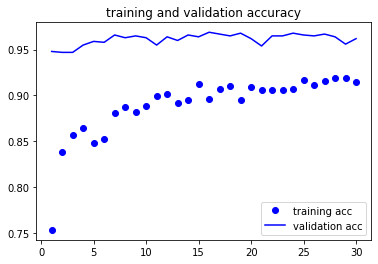

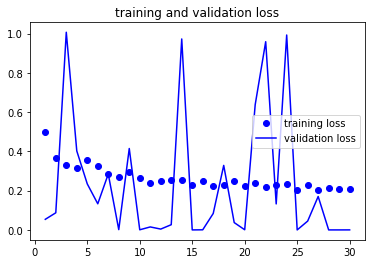

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

Unfreezing the conv base - in my case this process appears to be the same as for VGG16

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2004 - acc: 0.9150 - val_loss: 0.0065 - val_acc: 0.9500
Epoch 2/100
100/100 [==============================] - 17s 170ms/step - loss: 0.2199 - acc: 0.9225 - val_loss: 0.1974 - val_acc: 0.9340
Epoch 3/100
100/100 [==============================] - 17s 172ms/step - loss: 0.2098 - acc: 0.9215 - val_loss: 0.3597 - val_acc: 0.9340
Epoch 4/100
100/100 [==============================] - 17s 172ms/step - loss: 0.2099 - acc: 0.9155 - val_loss: 0.0178 - val_acc: 0.9370
Epoch 5/100
100/100 [==============================] - 17s 172ms/step - loss: 0.1945 - acc: 0.9255 - val_loss: 0.1887 - val_acc: 0.9350
Epoch 6/100
100/100 [==============================] - 17s 171ms/step - loss: 0.2015 - acc: 0.9260 - val_loss: 0.1615 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 17s 170ms/step - loss: 0.1848 - acc: 0.9260 - val_loss: 0.4790 - val_acc: 0.9400
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

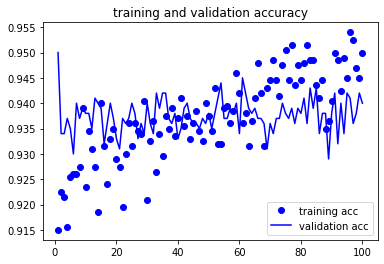

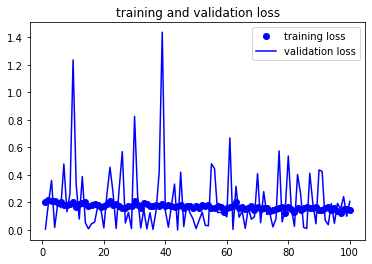

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

The overfitting problem presented in the VGG16 example appears to be relatively reduced. However, ResNet50 presents its own flavor of issues.

While at first glance the values in the accuracy graph look almost sporadic, a closer look at the interval on the y axis actually shows that the values are very close together - so close that matplotlib had to zoom in much more than with VGG16.

The numbers themselves show that my implementation ResNet50 leads to more accurate results than VGG16! However, the unusually high variability in the validation loss is troubling, and I would like to decrease that in my next iteration.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.20753124356269836
Validation accuracy: 0.9399999976158142


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

The following block of code throws an exception for me despite being exactly copied from the code given to us - I am disregarding this as it does not affect the actual model, and the file can still be manually downloaded through the sidebar at the left.

In [0]:
# from google.colab import files

# with open(model_fname, 'r') as f:
#   files.download(model_fname)

Sources used:


*   https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF#scrollTo=Fh6gZSeAjF7c
*   https://keras.io/applications/
*   https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

